## import useful packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim.models import KeyedVectors
from nltk import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
import re
import string

from sklearn.model_selection import train_test_split
from langdetect import detect
from sklearn.metrics import classification_report,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

%matplotlib inline  

## reading data

In [4]:
spam = pd.read_csv('csv/spam.csv')
not_spam = pd.read_csv('csv/not_spam.csv')
stream_dont_know = pd.read_csv('csv/stream_dont_know.csv')

spam = spam.rename(columns={"Unnamed: 0": "id"})
not_spam = not_spam.rename(columns={"Unnamed: 0": "id"})
stream_dont_know = stream_dont_know.rename(columns={"Unnamed: 0": "id"})

In [5]:
spam.head()

,id,subject,body,label
0,0,you don _ t know how to get into search engine...,submitting your website in search engines may ...,1
1,1,sterling balance sheet strengthens underpriced...,secured data inc . ( scre )'emerging leader in...,1
2,2,topcoat best m = eds here anyplace',i asked a conductor one day at what time the't...,1
3,3,"updates for clients sun , 03 jul 2005 .'","subject : updates for clients sun , 03 jul 200...",1
4,4,"re : knjecmo , intrepid investors report for s...","dane dempsey ,'emerging enterprise solutions ,...",1


In [8]:
data = spam.append(not_spam)

In [11]:
assert len(spam)+len(not_spam)==len(data), "sanity check 1"

## Preprocessing

### remove stopwords, stemming, remove digits, remove punctuation

In [10]:
stpwrd = stopwords.words('english')
def preprocess(review, stopwords, remove_stopwords=True,stemming = False):
    review = re.sub(' +',' ',review)# strip extra white space
    review = re.sub("'s",'',review) #replace 's with space 
    review = re.sub("/",' ',review) # replace / with space
    review = re.sub("-",' ',review)
    review = re.sub("`",' ',review)
    review = re.sub(" \d+", "", review) #remove digits
    #review = re.sub("-",'_',review)
    review = review.strip()
    review= review.lower()
    ####
    sent=[]
    punct= set(string.punctuation)- set(('?', '!',))
    
    words = word_tokenize(review)
    
    words= [token for token in words if token not in punct] #Remove punctuation
    if remove_stopwords:
        words= [token for token in words if token not in stopwords]

        
    if stemming:     #perform stemming 
        stemmer = nltk.stem.PorterStemmer()
        tokens_stemmed = list()
        
        for token in words:
            tokens_stemmed.append(stemmer.stem(token))
        words = tokens_stemmed

            
    sentence = ' '.join(word for word in words)
    sent.append(sentence)
        
    return sentence

#### preprocessing on subject 

In [11]:
%%time
tmp_sbj = []
subject_lang = []
for i,mail in enumerate(data.subject):
    tmp_sbj.append(preprocess(mail,stpwrd,stemming=True))
    try:
        subject_lang.append(detect(str(mail)))
    except:
        subject_lang.append('unknown')
    if i%5000==0:
        print(i)
data.subject = tmp_sbj

0
5000
10000
15000
CPU times: user 2min 26s, sys: 7.98 s, total: 2min 34s
Wall time: 2min 34s


#### preprocessing on body 

In [12]:
tmp_body = []
body_lang = []
for i,mail in enumerate(data.body):
    
    tmp_body.append(preprocess(str(mail),stpwrd,stemming=True))
    try:
        body_lang.append(detect(str(mail)))
    except:
        body_lang.append('unknown')
    if i%5000==0:
        print(i)

data.body = tmp_body

0
5000
10000
15000


#### Visualization- bar plot for each language 

In [13]:
subject_count = {}
for word in subject_lang :
    if word in subject_count :
        subject_count[word] += 1
    else:
        subject_count[word] = 1

In [14]:
body_count = {}
for word in body_lang :
    if word in body_count :
        body_count[word] += 1
    else:
        body_count[word] = 1

Text(0.5,1,'language that used in emails')

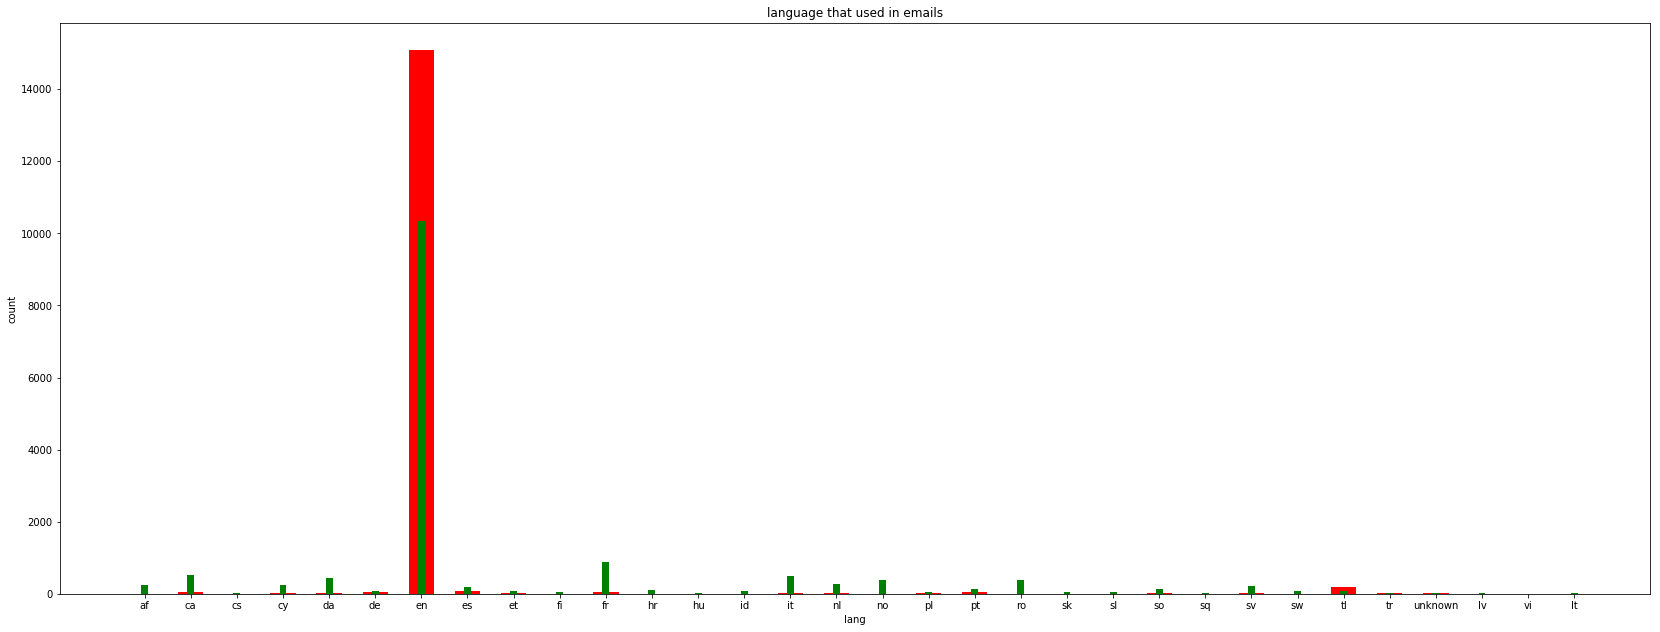

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(28.5, 10.5)
bar_width = 0.15
figsize=(15, 8)
opacity = 0.8
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(body_count.keys(), body_count.values(), bar_width+0.4, color='r')

rects2 = plt.bar(subject_count.keys(), subject_count.values(), bar_width, color='g')

plt.xlabel('lang')
plt.ylabel('count')
plt.title('language that used in emails')

##### it seems that most of the emails are in english 

## First feature

### Word_vectorizer    ( using tf-idf instead of bag of words )

In [16]:
vectorizer = TfidfVectorizer()

In [17]:
tmp_vect = []
for i in range(len(data)): 
    tmp_vect.append(data.subject.iloc[i] +' '+ data.body.iloc[i])

In [18]:
Word_vectorizer = vectorizer.fit_transform(tmp_vect).toarray()

In [19]:
feature_names = vectorizer.get_feature_names()

In [20]:
features = pd.DataFrame(Word_vectorizer,columns=[feature_names])

In [21]:
label = data['label'].values.tolist()

## Second feature

### length feature 

In [22]:
tmp = (data['body'].map(lambda text: len(text))+ data['subject'].map(lambda text: len(text))).values.tolist()
features['txt_length'] = tmp

### feature importance

In [27]:
from sklearn.ensemble import ExtraTreesClassifier

In [28]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=10,
                              random_state=0)

forest.fit(features, label)
print('Fitted')
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Top 10 Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))



Fitted
Top 10 Feature ranking:
1. feature 29213 (0.035247)
2. feature 15221 (0.020668)
3. feature 94433 (0.016618)
4. feature 41860 (0.016203)
5. feature 20083 (0.012760)
6. feature 7431 (0.011840)
7. feature 87246 (0.011685)
8. feature 34162 (0.009203)
9. feature 48598 (0.008371)
10. feature 22149 (0.007995)


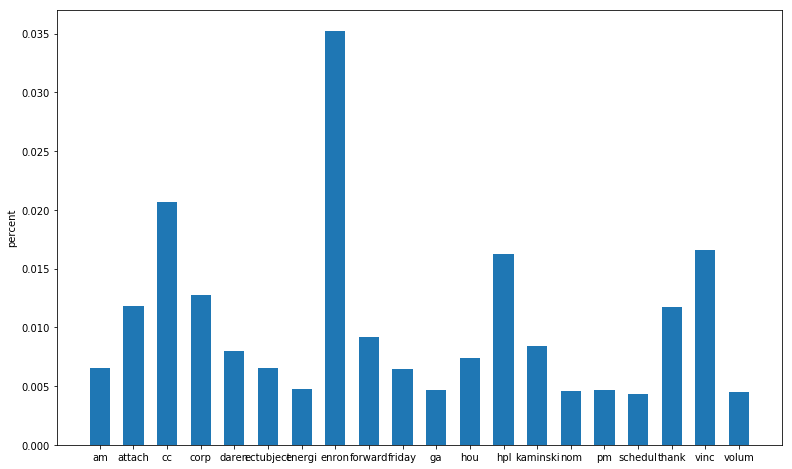

In [76]:
import matplotlib.pyplot as plt

name = []
for i in indices[0:20].tolist():
    name.append(features.columns.values[i][0])


key = name
values = importances[indices[0:20]].tolist()
plt.figure(figsize=(13,8))

res1= plt.bar(key, values, 0.6)
plt.ylabel('percent')
plt.show()
plt.savefig('distribution.png')

## Train model

In [77]:
X_train, X_test, y_train, y_test = train_test_split(features,label , test_size=0.33, random_state=42)

In [78]:
def grid_search(train_x, train_y, test_x, test_y, parameters, pipeline):
    grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=1, verbose=10)
    grid_search_tune.fit(train_x, train_y)

    print
    print("Best parameters set:")
    print (grid_search_tune.best_estimator_.steps)
    print

    # measuring performance on test set
    print ("Applying best classifier on test data:")
    best_clf = grid_search_tune.best_estimator_
    
    print('grid_search_tune.best_estimator : ',grid_search_tune.best_estimator_.steps[0])
    return best_clf

In [79]:
def logisticRegression(x_train, x_test, y_train, y_test):
        
    print ("LogisticRegression")
    pipeline = Pipeline([
        ('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=1)),
    ])
    parameters = {
        "clf__estimator__C": [0.1,1,10,30,50],
        "clf__estimator__class_weight": [None],
    }
    clf = grid_search(x_train, y_train, x_test, y_test, parameters, pipeline)
    return clf

In [80]:
best_model = logisticRegression(X_train, X_test, y_train, y_test)

LogisticRegression
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None ........
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, score=0.8873532752745172, total= 1.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None ........
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, score=0.8907403900776368, total= 1.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


[CV] clf__estimator__C=1, clf__estimator__class_weight=None ..........
[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, score=0.9617569102612646, total= 1.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.9min remaining:    0.0s


[CV] clf__estimator__C=1, clf__estimator__class_weight=None ..........
[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, score=0.9592880136337815, total= 1.1min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.2min remaining:    0.0s


[CV] clf__estimator__C=10, clf__estimator__class_weight=None .........
[CV]  clf__estimator__C=10, clf__estimator__class_weight=None, score=0.9712230215827338, total= 1.1min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.5min remaining:    0.0s


[CV] clf__estimator__C=10, clf__estimator__class_weight=None .........
[CV]  clf__estimator__C=10, clf__estimator__class_weight=None, score=0.9727324370384397, total= 1.1min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  7.8min remaining:    0.0s


[CV] clf__estimator__C=30, clf__estimator__class_weight=None .........
[CV]  clf__estimator__C=30, clf__estimator__class_weight=None, score=0.978227943960621, total= 1.1min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  9.1min remaining:    0.0s


[CV] clf__estimator__C=30, clf__estimator__class_weight=None .........
[CV]  clf__estimator__C=30, clf__estimator__class_weight=None, score=0.9702707820488544, total= 1.1min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 10.4min remaining:    0.0s


[CV] clf__estimator__C=50, clf__estimator__class_weight=None .........
[CV]  clf__estimator__C=50, clf__estimator__class_weight=None, score=0.9748201438848921, total= 1.1min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 41.1min remaining:    0.0s


[CV] clf__estimator__C=50, clf__estimator__class_weight=None .........
[CV]  clf__estimator__C=50, clf__estimator__class_weight=None, score=0.9693239916682447, total= 1.1min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 42.5min finished


Best parameters set:
[('clf', OneVsRestClassifier(estimator=LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1))]
Applying best classifier on test data:
grid_search_tune.best_estimator :  ('clf', OneVsRestClassifier(estimator=LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1))


In [81]:
predicted = best_model.predict(X_test)

In [82]:
X_test.shape

(5203, 102259)

In [84]:
print(classification_report(y_test,predicted))

             precision    recall  f1-score   support

          0       0.99      0.95      0.97      1962
          1       0.97      1.00      0.98      3241

avg / total       0.98      0.98      0.98      5203



In [85]:
predicted

array([0, 0, 1, ..., 1, 0, 0])

### We need three class 0 for non spam 1 for spam and something like 2 for suspicious


#### so we gonna use predict probability instead of predict to see how can we make 3 different classes

In [86]:
predicted_proba = best_model.predict_proba(X_test)

In [87]:
def column(matrix, i):
    return [row[i] for row in matrix]

predicted_proba_first_column = column(predicted_proba, 1)

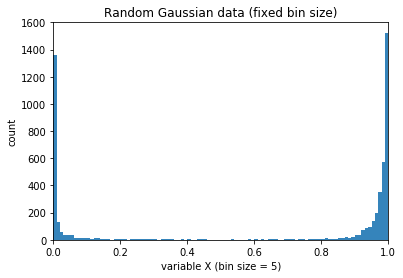

In [88]:
import numpy as np
import random
from matplotlib import pyplot as plt

data = predicted_proba_first_column 

# fixed bin size
bins = np.arange(-100, 100, 0.01) # fixed bin size

plt.xlim([min(data), max(data)])

plt.hist(data, bins=bins, alpha=0.9)
plt.title('Random Gaussian data (fixed bin size)')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')

plt.show()

#### For example wee can set between [0, 0.19)==>0    [0.19,0.85)==>2   [0.85,1]==>1

In [89]:
def cluster(a):
    if a < 0.19:
        a=0
    elif a >= 0.19 and a<0.85:
        a=2
    else: # a>=0.85
        a=1

    return a

In [90]:
predict3=[]
for i in predicted_proba_first_column:
    predict3.append(cluster(i))

#### now we can use collection package too see values on our three classes

In [91]:
from collections import Counter

Counter(predict3) # counts the elements' frequency

Counter({0: 1770, 1: 3200, 2: 233})

### We will make our feature based on previous vectorizer

In [92]:
%%time
tmp_sbj = []
subject_lang = []
for i,mail in enumerate(stream_dont_know.subject):
    tmp_sbj.append(preprocess(mail,stpwrd,stemming=True))
    
    if i%5000==0:
        print(i)
stream_dont_know.subject = tmp_sbj

0
5000
CPU times: user 1.55 s, sys: 19 ms, total: 1.57 s
Wall time: 1.57 s


In [93]:
tmp_body = []
body_lang = []
for i,mail in enumerate(stream_dont_know.body):
    
    tmp_body.append(preprocess(str(mail),stpwrd,stemming=True))

    if i%5000==0:
        print(i)

stream_dont_know.body = tmp_body

0
5000


In [94]:
tmp_vect = []
for i in range(len(stream_dont_know)): 
    tmp_vect.append(stream_dont_know.subject.iloc[i] +' '+ stream_dont_know.body.iloc[i])

In [95]:
stream_feature= pd.DataFrame(vectorizer.transform(tmp_vect).toarray())

In [96]:
tmp = (stream_dont_know['body'].map(lambda text: len(text))+ stream_dont_know['subject'].map(lambda text: len(text))).values.tolist()
stream_feature['txt_length'] = tmp


In [97]:
not_in_pretrained_stream_subject = []
for subject in stream_dont_know.subject:
    words = word_tokenize(subject)
    not_embedded_count = 0
    for i, word in enumerate(words):
        try:
            google_vecs.word_vec(word)
        except:
            not_embedded_count+=1
            pass
    not_in_pretrained_stream_subject.append(not_embedded_count)

In [98]:
not_in_pretrained_stream_body = []
for subject in stream_dont_know.body:
    words = word_tokenize(str(subject))
    not_embedded_count = 0
    for i, word in enumerate(words):
        try:
            google_vecs.word_vec(word)
        except:
            not_embedded_count+=1
            pass
    not_in_pretrained_stream_body.append(not_embedded_count)

In [99]:
stream_feature['sbj_no_w2v'] = not_in_pretrained_stream_subject
stream_feature['body_no_w2v'] = not_in_pretrained_stream_body

In [100]:
stream_feature.shape

(7179, 102259)

### predict 

In [101]:
predicted_proba_stream = best_model.predict_proba(stream_feature)

In [102]:
predicted_proba_stream_first_column = column(predicted_proba_stream, 1)

In [103]:
list_result=[]
for i in predicted_proba_stream_first_column:
    list_result.append(cluster(i))

In [104]:
dict_unique=Counter(list_result)

In [105]:
dict_unique

Counter({0: 2734, 1: 4106, 2: 339})

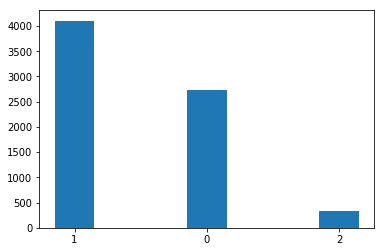

In [106]:
labels, values = zip(*(dict_unique).items())

indexes = np.arange(len(labels))
width = 0.3

plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.show()

In [107]:
final_result_df = stream_dont_know.copy()
final_result_df['label'] = list_result

In [108]:
final_result_df.head()

,id,subject,body,label
0,0,test internet pharmaci buy viagra med,visit doctor need safe easi 'b '' like email e...,1
1,1,hpl nom may,see attach file hplno xl hplno xl,0
2,2,black marlin ua meter,michael 'can back date deal start black marlin...,0
3,3,read email chang life,dear homeown 'you pre approv home low'fix rate...,1
4,4,special price rxdrug precis put buck back pocket,chernist site provid custom quick legitim acce...,1
